In [2]:
%%writefile synt/const.py

CHUNK = 1024
SRATE = 48000
TIME = SRATE
TEST_TIME = SRATE*3

# notas = {
#     'C': 523.251,   # do
#     'D': 587.33,    # re
#     'E': 659.255,   # mi
#     'F': 698.456,   # fa
#     'G': 783.991,   # sol
#     'A': 880,       # la
#     'B': 987.767,   # si
#     'c': 1046.502,  # do
#     'd': 1174.659,  # re
#     'e': 1318.51,   # mi
#     'f': 1396.913,  # fa
#     'g': 1567.982,  # sol
#     'a': 1760,      # la
#     'b': 1975.533,  # si
# }

# mapeo de teclas del ordenador a notas en el piano
# utilizamos '.' para los sostenidos
teclas = "zsxdcvgbhnjmq2w3er5t6y7u"  # 2 de teclas filas 
notas =  "C.D.EF.G.A.Bc.d.ef.g.a.b"  # mapeadas a 2 octavas
# notas =  ""
#         octava baja||octava alta


# frecuencias de las notas asocidas a las teclas del teclado
# partimos del la=220Hz y generamos frecuencias de escala temperada
pitchs = [ 220*2.0**(i/12.0) for i in range(len(teclas))] 

# frecuencias asociadas a las notas midi de 0 a 127
# El LA central es la nota midi 70 y su frecuencia es 440
# contruimos hacia abajo y hacia arriba el resto de notas
freqsMidi = [ 440*2.0**(i/12.0) for i in range(-69,59)]


notasAJ = [440, 495,      550,    586.67, 660,    733.33, 825]
notasAT = [440, 493.88,   554.36, 587.33, 659.26, 739.99, 830.61]
# notasAJ = [440, 466.16, 495, 523.25, 550, 586.67, 622.25, 660, 698.46, 733.33, 825] #las negras estan inventadas
# notasAT = [440, 466.16, 493.88, 523.25, 554.36, 587.33, 622.25, 659.26, 698.46, 739.99, 830.61]

#array que guarda los tonos hasta la siguiente nota con nombre (sin #)
aqglthlsncn = [2, 0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0] # no se usa

def getdiatonic(n, notas=notasAJ): #TODO: va raro
    pos = n % 7
    oct = n // 7
    return notas[pos] * (2 ** oct)

def diatonicAcorde(n, notas=notasAJ):
    "Devuelve el acorde diatonico relacionado con la frecuencia dada"
    _n = n
    return [getdiatonic(n, notas), getdiatonic( n + 2, notas), getdiatonic(n + 4, notas)]

def timeToFrame(t): return round(t*SRATE)

Overwriting synt/const.py


In [3]:
%%writefile synt/envolv.py

from synt.const import *
import numpy as np
from tkinter import *



'''Envolvente: Recibe una serie de puntos y crea una funcion que los recorre'''
class Env:
    def __init__(self, fun, nombre="Env", show=True):
        self.fun = fun
        self.frame = 0
        self.nombre = nombre
        self.show = show
    
    def next(self, tiempo=None):
        _tiempo = []
        if tiempo is None: # guarda su propio frame si no le dan uno
            _tiempo = np.arange(self.frame, self.frame + CHUNK)
            self.frame += CHUNK
        else:
            _tiempo = tiempo
            self.frame = tiempo[0]
        part = self.fun(_tiempo)
        if (len(part) < CHUNK):
            part = np.concatenate((part, np.zeros(CHUNK-len(part))))
        return part
    
    def doShow(self, tk:Tk, bg="#808090", side=LEFT):
        '''crea un frame con su nombre para meter dentro sus elementos de forma recursiva'''
        if self.show is False:
            return None # para que acabe la recursion
        _tk = LabelFrame(tk, text=self.nombre, bg=bg)
        _tk.pack(side=side)
        return _tk    
    
    def addNombre(self, nombre):
        self.nombre = nombre
        
    def reset(self):
        self.frame = 0
        
    
class NoEnv(Env):
    def __init__(self, nombre="Env", show=True):
        super().__init__(self.fun)
        
    def fun(self, tiempo=None):
        return np.full(CHUNK, 1)
    
class EnvPP(Env):
    def __init__(self, points, nombre="Env", show=True):
        super().__init__(self.fun, nombre, show)
        env = np.zeros(0)
        # generamos la envolvente
        x0, y0 = points[0]
        
        _points = points[1:]
        if x0 != 0: # si el primero es 0, usamos el valor de y0, si no, empezamos en 0,0
            x0, y0 == 0, 0
            _points =np.concatenate(([(0,0)], points))
            
            
        for x, y in _points:
            x = round(x*SRATE) # traducir a segundos
            if x < 0: 
                x = 0
            env = np.concatenate((env, np.linspace(y0,y,x+1)[:-1])) # he quitado el [:-1] y no parece cambiar
            x0, y0, = x, y
        self.lastY = 0
        
        self.env = env
        
    def fun(self, tiempo=None):
        part = np.zeros(0)
        if (self.frame > len(self.env)):
            part = np.full(CHUNK, self.lastY)
            # print(self.lastY)
        else:
            part = self.env[self.frame:self.frame+CHUNK]
            rest = CHUNK - len(part)
            self.lastY = part[-1]
            if (len(part) < CHUNK):
                part = np.concatenate((part, np.full(rest, self.lastY)))
                
        self.lastY = part[-1]
        return part

# Esta envolvente tiene la duracion fija, no vale para el instrumento
class EnvADSR(EnvPP):
    '''
    atk, rel y sus van en segundos
    atk = segundos que tarda en crecer
    dec = segundos que tarda en alcanzar el sustain
    sus = valor que coge al decaer
    rel = segundos que tarda en decrecer
    dur = duracion total de la señal
    '''
    def __init__(self, atk, dec, sus, rel, dur, nombre="Env", show=True):
        _atk = (atk, 1)
        _dec = (dec, sus)
        _sus = (dur - rel, sus)
        _rel = (rel, 0)
        super().__init__([_atk, _dec, _sus, _rel], nombre, show)

# Esta envolvente tiene tres estados, atk, rel y off
class EnvInstrumento:
    '''
    atk, rel y sus van en segundos
    atk = segundos que tarda en alcanzar el maximo
    dec = segundos que tarda en alcanzar el sustain
    sus = valor que coge al decaer
    rel = segundos que tarda en decrecer
    '''
    def __init__(self, atk, dec, sus, rel, nombre="Env", show=True):
        # _atk = (atk, 1)
        # _dec = (dec, sus)
        # _rel = (rel, 0)
        
        _atk = atk
        _dec = dec 
        _sus = sus
        _rel = rel
        
        # _sus = (dur - rel, sus)
        
        self._rel = _rel
        self._atk = _atk
        self._dec = _dec
        self._sus = _sus
        self.show = show
        self.nombre = nombre
        
        self.envAtk = EnvPP([(0,0), (self._atk, 1), (self._dec, self._sus)], nombre, show) # empieza en 0, sube a 1 y luego decae a sus
        self.envRel = EnvPP([(0,self._sus), (self._rel, 0)], nombre, show) # empieza en sus y baja hasta 0 en rel segundos
        self.state = 'atk'
        
    
    def next(self, tiempo=None):
        ret = 0
        # print(self.state)
        if self.state == 'atk':
            ret = self.envAtk.next()
            # print(ret[0])
        elif self.state == 'rel':           
            ret = self.envRel.next()
            if self.envRel.frame > self._rel * SRATE:
                # print(self.rel.frame)
                # print(self._rel[0])
                print('off')
                self.state = 'off'
        elif self.state == 'off':
            # return 0
            return np.zeros(CHUNK)
        return ret 
        
    '''TODO: podria hacer una funcion noteOn para que si se vuelve a activar una nota que ya estaba sonando
        en vez de acabarse de golpe y empezar de 0, que empieze self.rel.lastY para que no sea tan brusco el cambio 
    '''    
    def noteOff(self):
        self.state = 'rel'#TODO: INFO era que tenia puesto == 
        self.envRel = EnvPP([(0,self.envAtk.lastY), (self._rel, 0)], self.nombre, self.show) # empieza en sus y baja hasta 0 en rel segundos
        
    def getLast(self):
        if self.state == 'atk':
            return self.envAtk.lastY
        if self.state == 'rel':
            return self.envRel.lastY
        if self.state == 'off':
            return 0

    def doShow(self, tk:Tk, bg="#808090", side=TOP):
        '''crea un frame con su nombre para meter dentro sus elementos de forma recursiva'''
        if self.show is False:
            return None # para que acabe la recursion
        
        _tk = LabelFrame(tk, text=self.nombre, bg=bg)
        
        s_atk=Scale(_tk, from_=0., to=2., resolution=0.05, orient=HORIZONTAL, label="atk", command=self.changeAtk)
        s_atk.set(self._atk)
        s_atk.pack(side=side)
        
        s_dec=Scale(_tk, from_=0., to=1., resolution=0.05, orient=HORIZONTAL, label="dec", command=self.changeDec)
        s_dec.set(self._dec)
        s_dec.pack(side=side)
        
        s_sus=Scale(_tk, from_=0., to=1., resolution=0.05, orient=HORIZONTAL, label="sus", command=self.changeSus)
        s_sus.set(self._sus)
        s_sus.pack(side=side)
        
        s_rel=Scale(_tk, from_=0., to=4., resolution=0.05, orient=HORIZONTAL, label="rel", command=self.changeRel)
        s_rel.set(self._rel)
        s_rel.pack(side=side)
        
        _tk.pack(side=side)
        
        return _tk  
    
    def changeEnvs(self):
            
        _atkFrame = self.envAtk.frame
        _relFrame = self.envRel.frame
        
        self.envAtk = EnvPP([(self._atk, 1), (self._dec, self._sus)], self.nombre, False) # empieza en 0, sube a 1 y luego decae a sus
        self.envRel = EnvPP([(0,self._sus), (self._rel, 0)], self.nombre, False) # empieza en sus y baja hasta 0 en rel segundos

        self.envAtk.frame = _atkFrame
        self.envRel.frame = _relFrame
         
    def changeAtk(self, val):
        self._atk = float(val)
        self.changeEnvs()
        
    def changeRel(self, val):
        self._rel = float(val)
        self.changeEnvs()
        
    def changeSus(self, val):
        self._sus = float(val)
        self.changeEnvs()
        
    def changeDec(self, val):
        self._dec = float(val)
        self.changeEnvs()
    
    def reset(self):
        self.envAtk.reset()
        self.envRel.reset()
        self.state = 'atk'

Overwriting synt/envolv.py


In [4]:
%%writefile synt/filter.py

from copy import deepcopy
from synt.function import *
from synt.const import *
from tkinter import *
import numpy as np

from synt.osc import *

# TODO ver si satura
class FilterIIR(Function):
    ''' recibe una funcion (generador de ondas) y devuelve su onda filtrada'''
    def __init__(self,signal:Function,alpha:Function, act=False, nombre='IIR',show=True):
        super().__init__(show, nombre)
        self.signal = signal
        self.mem = 0
        
        self.alpha = alpha
        _am = alpha.next(np.arange(0, CHUNK))
        
        if isinstance(_am, (list, np.ndarray)):
            self.alpha_mem = _am
        else:
            self.alpha_mem = 0
        # self.step = step 
        # por defecto inactivo
        self.act = act

    def fun(self, tiempo):
        data = self.signal.next(tiempo)
        
        _alf = self.alpha.next(tiempo)
        if isinstance(_alf, (list, np.ndarray)):
            _alpha = _alf
        else:
            _alpha = np.full(CHUNK, _alf)
        
        if self.act:
            data[0] = self.mem + self.alpha_mem * (data[0]-self.mem)
            for i in range(1,CHUNK):
                data[i] = data[i-1] + _alpha[i] * (data[i]-data[i-1])
            self.mem = data[CHUNK-1]
            
        self.mem = data[-1] # actualizamos memo con ultima muestra
        self.alpha_mem = float(_alpha[-1])
        
        return data

    def toggle(self):
        self.act = not self.act
        print(f"filter {self.nombre}: {'on' if self.act else 'off'}")

    def activate(self):
        self.act = True

    def deactivate(self):
        self.act = False    

    def isActive(self):
        return self.act

    def doShow(self, tk, bg="#808090", side=TOP):
        _tk = super().doShow(tk, bg, side=TOP)
        # TODO hacer un boton para activar/desactivar
        self.alpha.addNombre('alpha')
        self.alpha.doShow(_tk, bg, side)
        act_button = Button(_tk, text='on/off', command=self.toggle)
        act_button.pack()
        return _tk
    # no hace falta teniendo el do show
    # def upAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha+self.step))

    # def downAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha-self.step))

class LPFilter(FilterIIR):
    def __init__(self,signal:Function,alpha:Function, act=False ,nombre='IIR',show=True):
        super().__init__(signal,alpha, nombre='LP',show=True)
        # _IIR1 = FilterIIR(Reverse(deepcopy(self.signal)), self.alpha, self.act)
        self.lp_0 = FilterIIR(deepcopy(self.signal), self.alpha, self.act)
        self.lp = FilterIIR(Reverse(self.lp_0), self.alpha, self.act)
        
    def fun(self, tiempo):
        if self.act:
            return self.lp_0.next(tiempo)
        else: 
            return self.signal.next(tiempo)
        # aplicamos dos veces para corregir el desplazamiento de fase
        
    def activate(self):
        self.act = True
        self.lp_0.activate()
        self.lp.activate()

    def deactivate(self):
        self.act = False  
        self.lp_0.deactivate()
        self.lp.deactivate

class HPFilter(FilterIIR):
    def __init__(self,signal:Function,alpha:Function, nombre='IIR',show=True):
        super().__init__(signal,alpha, nombre='LP',show=True)
        self.filt_alpha = C(2) - alpha
        self.lp = LPFilter(signal,self.filt_alpha, self.act)
    
    def fun(self, tiempo):
        if self.act:
            _sig = self.signal.next(tiempo)
            _lp = self.lp.next(tiempo)
            '''suena muy bajo'''
            return _sig - _lp
        else: 
            return self.signal.next(tiempo)
        
    def activate(self):
        self.act = True
        self.lp.activate()

    def deactivate(self):
        self.act = False  
        self.lp.deactivate

Overwriting synt/filter.py


In [5]:
%%writefile synt/function.py
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy.signal as sg
from synt.const import *

from tkinter import *

'''
    Funciones: Al usar .next(tiempo), devuelven un np.array con los 
    valores que representan la función en el tiempo especificado.
    Pensadas para emular la programacion declarativa
    
'''

class Function:
    def __init__(self, show=False, nombre=""):
        self.frame = 0 
        self.nombre = nombre
        self.show = show # empieza a false para que solo se pueda cambiar una vez
    
    def __mul__(self, other):
        return Mult(self, other)
    
    def __truediv__(self, other):
        return Div(self, other)
    
    def __add__(self, other):
        return Add(self, other)
    
    def __sub__(self, other):
        return Sub(self, other)
    
    def __neg__(self):
        return Neg(self)
    
    def __pow__(self, other):
        return Exp(self)

    def next(self, tiempo = None):
        _tiempo = tiempo
        if tiempo is None: 
            _tiempo = np.arange(self.frame, self.frame + CHUNK)
            self.frame += CHUNK
        return self.fun(_tiempo) # devuelve vacío
    
    def fun(self, tiempo):
        '''esto es lo que se modiica en cada implementacion de Function'''
        return np.zeros(CHUNK)
    
    def doShow(self, tk:Tk, bg="#808090", side=LEFT):
        '''crea un frame con su nombre para meter dentro sus elementos de forma recursiva'''
        if self.show is False:
            return None # para que acabe la recursion
        
        _tk = LabelFrame(tk, text=self.nombre, bg=bg)
        
        _tk.pack(side=side)
        return _tk             
    
    def addNombre(self, n): # no se si se va a usar pero weno
        if n != "" and self.nombre != "":
            n = str(n) + ":"
        self.nombre = n + self.nombre
    
    
# TODO: hacer el show de las operaciones
class Add(Function): # f(x) = g(x) + h(x)
    def __init__(self, g, h):
        super().__init__(False)
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g + _h
    
class Sub(Function): # f(x) = g(x) - h(x)
    def __init__(self, g, h):
        super().__init__(False)
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g - _h  
    
class Mult(Function): # f(x) = g(x) * h(x)
    def __init__(self, g, h):
        super().__init__(False)
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g * _h
    
class Div(Function): # f(x) = g(x) / h(x)
    def __init__(self, g, h):
        super().__init__(False)
        self.g = g
        self.h = h
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _h = self.h.next(tiempo)
        return _g / _h  

class Neg(Function):
    def __init__(self, g):
        super().__init__(False)
        self.g = g
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        return -_g
    
# TODO añadir el otro valor del log
#f(x)=log(10,x .9+.1)+1 <-
class Log(Function):
    def __init__(self, g):
        super().__init__(False)
        self.g = g
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        return np.log(_g)

class Exp(Function):
    def __init__(self, g, e):
        super().__init__(False)
        self.g = g
        self.e = e
        
    def fun(self, tiempo):
        _g = self.g.next(tiempo)
        _e = self.e.next(tiempo)
        return _g ** _e
    
class Const(Function): # f(t) = valor
    def __init__(self, valor, nombre="C", show=False, fr=None, to=None, step=None):
        super().__init__(show, nombre)
        self.valor = valor
        self.fr = fr
        self.to = to
        self.step = step
        
        _valor = valor
        if valor == 0: # cuando es 0 se lia
            _valor = 1
        
        if step is None:
            self.step = _valor / 1000
        if fr is None:
            # self.fr = valor - 1000 * self.step
            self.fr = 0
        if to is None:
            self.to = _valor + 1500 * self.step
        

        # if show:
            # self.doShow()
        
    def fun(self, tiempo):
        return self.valor # más rápido
        # return np.full(CHUNK, self.valor)
        
    def setVal(self, val):
        self.valor = float(val)
        
    def doShow(self, tk:Tk, bg="#808090", side=LEFT, orient=HORIZONTAL):
        '''crea un frame con su nombre para meter dentro sus elementos de forma recursiva'''
        '''Const es un caso especial porque es un caso base'''
        
        if self.show is False:
            return None # para que acabe la recursion
        
        # hacemos un slider y lo metemos en root
        slider=Scale(tk, from_=self.fr, to=self.to, resolution=self.step, orient=orient, label=self.nombre, command=self.setVal)
        slider.set(self.valor)
        slider.pack(side=side)
        
        # _tk = super().doShow(tk)
        # self.fr.doShow(_tk)
        # self.to.doShow(_tk)
        # self.step.doShow(_tk)
        
        return tk # diria que no hace falta pero bueno

class C(Const): # misma que const pero mas corta
    def __init__(self, valor, nombre="", show=False, fr=None, to=None, step=None):
        super().__init__(valor, nombre, show, fr, to, step)
        
class X(Function): # f(t) = valor*t
    def __init__(self, valor=C(1), avoid0 = False, nombre="X", show=False):
        super().__init__(show, nombre)
        self.valor = valor
        self.avoid0 = avoid0
        if self.show:
            self.doShow()
    
    def fun(self, tiempo):
        z = 0
        _valor = self.valor / C(SRATE)
        if self.avoid0:
            z = 0.000001
        return tiempo * _valor.next(tiempo) + z
    
    def doShow(self,  tk:Tk):
        _tk = super().doShow(tk)
        if _tk is None:
            return None  
        self.valor.addNombre(self.nombre)
        self.valor.doShow(_tk)
    
class XP(Function):
    def __init__(self, valor=C(1), exp=C(1), avoid0 = False, nombre="X^exp", show=False):
        super().__init__(show, nombre)
        self.exp = exp
        self.avoid0 = avoid0
        self.val = X(valor, False, "X", show)
        if self.show:
            self.doShow()
    
    def fun(self, tiempo):
        z = 0
        if self.avoid0:
            z = 0.000001
        return self.val.next(tiempo) ** self.exp.next(tiempo) + z
    
    def doShow(self,  tk:Tk):
        _tk = super().doShow(tk)
        if _tk is None:
            return None  
        # if _tk is None:
        #     print("No has introducido un Tk")
        #     return None # para que acabe la recursion
        # print("Has introducido un Tk")
        
        self.val.addNombre(self.nombre) 
        self.val.doShow(_tk) # añade el valor al frame
        self.exp.addNombre("exp") # creo
        self.exp.addNombre(self.nombre)
        self.exp.doShow(_tk) # añade el exponente al frame

class Noise(Function):
    def fun(self, tiempo):
        return np.random.uniform(-1,1,CHUNK)

class Reverse(Function): # reverse en un chunk (es lo que necesitamos por ahora)
    def __init__(self, func:Function, show=False, nombre=""):
        super().__init__(show, nombre)
        self.func = func
        
    def fun(self, tiempo):
        onda = self.func.next(tiempo)
        return onda[::-1]

Overwriting synt/function.py


In [6]:
%%writefile synt/instrumento.py
import numpy as np
from tkinter import *

from copy import deepcopy
import math

from synt.const import *
from synt.synt import *
from synt.osc import *
from synt.function import *
from synt.envolv import *
from synt.effects import *
from synt.instrumento import *
from synt.mixer import *

class Instrumento(Function):
    def __init__(self, synt, env, show=True, nombre='Instrumento'):
        super().__init__(show, nombre)
        # Creación de los osciladores
        # self.mixer = Mixer()
        self.synt = synt
        self.env = env
        # canales indexados por la nota de lanzamiento -> solo una nota del mismo valor
        self.channels = dict()        
        self.tails = dict()
        # self.afinacion = notasAJ

        self.octava = 4
        
    def noteOn(self,midiNote):
        # si está el dict de canales apagamos nota actual con envolvente de fadeout
        # y guardamos en tails. El next devolverá este tail y luego comenzará la nota
        if midiNote in self.channels:                   
            lastAmp = self.channels[midiNote].getEnv().getLast() # ultimo valor de la envolvente: inicio del fadeOut
            # signal = self.channels[midiNote].next()     # señal          
            # self.tails[midiNote] = signal           # diccionario de tails (notas apagadas) 

        # generamos un nuevo synth en un canal indexado con notaMidi
        # con los parámetros actuales del synth
        # if self.afinacion_box.get() == 'Ajustada' and self.afinacion != notasAJ:
        #     self.afinacion = notasAJ
        #     print('AJ')
        # elif (self.afinacion_box.get() == 'Atemperada' and self.afinacion != notasAT):
        #     print('AT')
        #     self.afinacion = notasAT
        
        freq = freqsMidi[midiNote] * 2 ** self.octava
        # print(freq)
        self.synt.reset()
        synt = deepcopy(self.synt)
        # synt.reset()
        self.env.reset()
        env = deepcopy(self.env)
        synt.setFreq(C(freq))
        synt.setEnv(env)
        self.channels[midiNote] = synt
        # self.channels[midiNote] = self.synt(midiNote, ondas = [osc.Sine()], env=EnvInstrumento(.01, .1, .7, .3)) #megasimple  
        
    def noteOff(self, midiNote):
        if midiNote in self.channels: # está el dict, release
            self.channels[midiNote].getEnv().noteOff()
            self.channels[midiNote].noteOff()
            
    def change_octava(self, val):
        self.octava = int(val) - 2

    # identificar y mandar reproducir la nota
    def down(self, event):
        c = event.keysym
        if c in teclas:
            midiNote = teclas.index(c) + 48
            freq = freqsMidi[midiNote] * 2 ** self.octava
            print(f'noteOn {midiNote} ({freq}Hz)')
            self.noteOn(midiNote)

    def up(self, event):
        c = event.keysym
        if c in teclas:
            midiNote = teclas.index(c) + 48# buscamos indice y hacemos el noteOff
            freq = freqsMidi[midiNote] * 2 ** self.octava
            print(f'noteOff {midiNote} ({freq}Hz)')
            self.noteOff(midiNote)
            
    def doShow(self, tk, bg="#808090", side=LEFT):
        _tk = super().doShow(tk)
        if _tk is None:
            return None        
        # _tk = LabelFrame(_frame, text=self.nombre, bg="#808090")        
        slider_octava =Scale(_tk, from_=-1, to=10, resolution=1, orient=HORIZONTAL, label="Octava", command=self.change_octava, length=310)
        slider_octava.set(self.octava)
        slider_octava.pack()
        
        # una ventana de texto interactiva para poder lanzar notas con el teclado del ordenador
        text = Text(_tk,height=4,width=40)

        text.pack(side=TOP)
        text.bind('<KeyPress>', self.down)
        text.bind('<KeyRelease>', self.up) 
              
        self.synt.doShow(_tk, bg, side)
        self.env.doShow(_tk, bg, side)
        return _tk  
            
    # siguiente chunck del generador: sumamos señal de canales y hacemos limpia de silenciados
    def next(self, tiempo=None):
        out = np.zeros(CHUNK)          
        for c in list(self.channels):            # convertimos las keys a lista para mantener la lista de claves original
            # print(self.channels[c].getEnv().state)
            if self.channels[c].getEnv().state == 'off':  # si no, modificamos diccionario en el bucle de recorrido de claves -> error 
                del self.channels[c]
            else: # si la nota está el diccionario de tails devolvemos el fadeout generado en noteOn y elminamos tail
                if c in self.tails:                  
                    out += self.tails[c]
                    del self.tails[c]
                else:
                    out += self.channels[c].next()
        # if out is list:       
            # out = out / np.max(out)
        if len(self.channels) > 0:
            # print(len(self.channels))
            fact = 1/math.sqrt(len(self.channels))
            out = out * fact
            # out = out /len(self.channels)
        return out

Overwriting synt/instrumento.py


In [7]:
%%writefile synt/midisequencer.py
import numpy as np
from tkinter import *

from copy import deepcopy
import math

from synt.const import *
from synt.synt import *
from synt.osc import *
from synt.function import *
from synt.envolv import *
from synt.effects import *
from synt.instrumento import *
from synt.mixer import *
import mido


class MidiSequencerTk:
    # análogo a lo anterior
    def __init__(self,tk,instruments=None):
        if instruments == None:
            env = EnvInstrumento(.1, .1, .7, .3)
            synt = Synt(C(1), Sine(C(1)))
            self.instruments = [Instrumento(tk, synt, env)]            
        else:
            self.instruments = instruments

        frame = LabelFrame(tk, text="Midi Sequencer", bg="#908060")
        frame.pack(side=TOP)

        frameFile = Frame(frame, highlightbackground="blue", highlightthickness=6)
        frameFile.pack(side=TOP)
        Label(frameFile,text='Archivo MIDI: ').pack(side=LEFT)
 
        self.file = Entry(frameFile) #.pack(side=RIGHT)
        self.file.insert(14,"pirates.mid")
        self.file.pack(side=LEFT)

        self.transport = 0
        
        for i in self.instruments:
            i.doShow(frame)
        
        self.text = Text(frame,height=6,width=23)
        self.text.pack(side=RIGHT)
        playBut = Button(frame,text="Play", command=self.play)
        playBut.pack(side=TOP)
        stopBut = Button(frame,text="Stop", command=self.stop)
        stopBut.pack(side=BOTTOM)

        self.tick = 1
        self.state = 'off'
        
    # obtención de la secuencia midi (noteOn/Off) con tiempos relativos al inicio
    def getSeq(self,midiEvents):
        seq = []
        accTime = 0
        for m in midiEvents:
            accTime += m.time
            if m.type=='note_on':
                if m.velocity==0: seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
                else: seq.append((accTime,'noteOn',m.note+self.transport,m.channel))    
            elif m.type=='note_off':
                seq.append((accTime,'noteOff',m.note+self.transport,m.channel))
        return seq

  
    def play(self):
        events = mido.MidiFile(self.file.get())
        seq = self.getSeq(events)
        print(seq)

        self.state = 'on'
        self.playLoop(seq)

    def playLoop(self,seq,item=0,accTime=0):   
        if item>=len(seq) or self.state =='off':
            return

        # ahora tenemos que procesar todos los ítems cuyo tiempo supere el crono accTime    
        while item<len(seq) and accTime>=seq[item][0]:
            (_,msg,midiNote,_chan) = seq[item]  # (time,'noteOff',midNote,channel)
            self.text.insert('6.0',  f'{msg} {midiNote} {_chan}\n') 
            if msg=='noteOn':  
                self.instruments[_chan % len(self.instruments)].noteOn(midiNote)                   
            else: # msg noteOff    
                self.instruments[_chan % len(self.instruments)].noteOff(midiNote)                   
            item += 1 # y avanzmos ítem

        # avanzammos crono 
        accTime += self.tick/1000

        self.text.after(self.tick,lambda: self.playLoop(seq,item,accTime)) 

         
    def stop(self):
        self.instruments.stop()
        self.state = 'off'   

Overwriting synt/midisequencer.py


In [8]:
%%writefile synt/mixer.py
import numpy as np
from synt.const import *
from synt.function import *
from math import sqrt

def sqr(oscs, tiempo):  
    n = len(oscs)  
    ret = np.zeros(CHUNK)
    if n == 0:          
        return ret      
    fact = 1/sqrt(n)        
    for o in oscs: 
        ret = ret + (o.next(tiempo) * fact)
    return ret

def media(oscs, tiempo):  
    n = len(oscs)  
    ret = np.zeros(CHUNK)
    if n == 0:          
        return ret      
    fact = 1/n        
    for o in oscs: 
        ret = ret + (o.next(tiempo) * fact)
    return ret

def tanh(oscs, tiempo):
    ret = np.zeros(CHUNK)
    for o in oscs: 
        ret = ret + o.next(tiempo)
    return np.tanh(ret)    

class Mixer(Function):
    def __init__(self, oscs:list[Function], fun=None):
        super().__init__()
        self.oscs = oscs
        self.mix = fun
        if fun == None:
            self.mix = sqrt
        
    def setOscs(self, oscs):
        self.oscs = oscs
        
    def fun(self, tiempo):
        return self.mix(self.oscs, tiempo)
    
    def doShow(self, tk, bg="#808090"):
        _tk = super().doShow(tk, bg)
        for o in range (0, len(self.oscs)):
            self.oscs[o].addNombre(str(o))
            self.oscs[o].doShow(_tk, bg, side=BOTTOM)
        return _tk

Overwriting synt/mixer.py


In [9]:
%%writefile synt/osc.py
import numpy as np
import scipy.signal as sg

from synt.const import *
from synt.function import *

''' 
    osciladores: generan una onda nparray con unos parametros dados,
    las características particulares (bpm, etc) se declaran al
    inicializar el objeto correspondiente de la clase Osc o sus derivadas.
'''

class Osc(Function):    
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp:Function=None, phase=C(0), nombre="", show=False):
        super().__init__(show, nombre)
        self.freq = freq
        self.phase = phase
        self.frame = 0
        if amp is None:
            self.max = max
            self.min = min
            self.amp = None

        else: 
            self.max = None
            self.min = None
            self.amp = amp
    
    # esto va a ser lo que se modifique
    def fun(self, tiempo):
        return np.zeros(len(tiempo))        
    
    def doShow(self, tk:Tk, bg="#808090", side=LEFT):
        _tk = super().doShow(tk, bg, side)
        if _tk is None:
            return None  
        self.freq.addNombre("freq")
        # self.freq.addNombre(self.nombre)
        self.freq.doShow(_tk, bg, side)
        if self.amp is not None:
            self.amp.addNombre("amp")
            # self.amp.addNombre(self.nombre)
            self.amp.doShow(_tk, bg, side)
        if self.max is not None:
            self.max.addNombre("max")
            self.max.doShow(_tk, bg, side)
        if self.min is not None:
            self.min.addNombre("min")
            self.min.doShow(_tk, bg, side)
        self.phase.addNombre("phase")
        # self.phase.addNombre(self.nombre)
        self.phase.doShow(_tk, bg, side)
        return _tk       
            
    def getFreq(self):
        return self.freq

    def setFreq(self, value):
        self.freq = value

    def getMax(self):
        return self.max

    def setMax(self, value):
        self.max = value

    def getMin(self):
        return self.min

    def setMin(self, value):
        self.min = value

    def getAmp(self):
        return self.amp

    def setAmp(self, value):
        self.amp = value

    def getPhase(self):
        return self.phase

    def setPhase(self, value):
        self.phase = value
        
    def noteOff(self):
        pass
    
    def reset(self):
        self.frame = 0
    
class Sine(Osc): # f(t) = amp * sin(t * 2pi * freq + phase)
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), nombre="Sine", show=False):
        super().__init__(freq, max, min, amp, phase, nombre, show)
        
    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        p3 = _freq/SRATE
        p2 = tiempo * (2 * np.pi)
        p1 = p2 * p3
        onda = np.sin(p1 + _phase)
        # onda = np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase)
        return onda * _amp + _offset
    
class Triangle(Osc): # f(t) = amp * arcsin(sin(t * 2pi * freq + phase)) * 2/pi   -> 2/pi es para que vaya de 1 a -1
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), nombre="Triangle", show=False):
        super().__init__(freq, max, min, amp, phase, nombre, show)

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        # funcion
        onda = (2 / np.pi) * np.arcsin(np.sin(tiempo * (2 * np.pi * _freq/SRATE) + _phase))
        return onda * _amp + _offset
    
class Sawtooth(Osc): # f(t) = amp * arctan(tan(t * 2pi * freq + phase)) * 2/pi   -> 2/pi es para que vaya de 1 a -1
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), nombre="Sawtooth", show=False):
        super().__init__(freq, max, min, amp, phase, nombre, show)

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        onda = (2 / np.pi) * np.arctan(np.tan(tiempo * (1 * np.pi * _freq/SRATE) + _phase))
        return onda * _amp + _offset

class Square(Osc):
    def __init__(self, freq:Function, max=C(1), min=C(-1), amp=None, phase=C(0), duty=C(.5), nombre="Square", show=False):
        super().__init__(freq, max, min, amp, phase, nombre, show)
        self.duty = duty # no implementado

    def fun(self, tiempo):
        _freq = self.freq.next(tiempo)
        _phase = self.phase.next(tiempo)
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(tiempo) - self.min.next(tiempo)) / 2
            _offset = (self.max.next(tiempo) + self.min.next(tiempo)) / 2
        else: 
            _amp = self.amp.next(tiempo)
        
        onda = sg.square((2*np.pi * tiempo) * _freq / SRATE + _phase)
        return onda * _amp + _offset

class Rep(Osc):
    '''repite una funcion en base a una frecuencia'''
    def __init__(self, freq:Function, func:Function, max=C(1), min=C(-1), amp=None, phase=C(0), nombre="Rep", show=False):
        super().__init__(freq, max, min, amp, phase, nombre, show)
        self.func = func
        
    def fun(self, tiempo):
        _phase = self.phase.next(tiempo)
        _tiempo = tiempo
        # _tiempo = tiempo + _phase # TODO: ver como sacar la fase
        _tiempo = _tiempo % (SRATE/self.freq.next()) # frecuencia en Hz
        _amp = None
        _offset = 0

        # si se usa amp o max min
        if self.amp is None:
            _amp = (self.max.next(_tiempo) - self.min.next(_tiempo)) / 2
            _offset = (self.max.next(_tiempo) + self.min.next(_tiempo)) / 2
        else: 
            _amp = self.amp.next(_tiempo)
        
        onda = self.func.next(_tiempo)
        
        return onda * _amp + _offset
    
    def doShow(self, tk, bg="#808090", side=LEFT):
        _tk = super().doShow(tk, bg, side)
        if _tk is None:
            return None  
        self.func.addNombre("func")
        self.func.doShow(_tk)
    
class Sampler(Osc):
    '''reproduce una onda una vez a una velocidad especificada'''
    def __init__(self, freq:Function, sample:list, og_freq:Function=None, amp=C(1), samedur=False, nombre="Sampler", show=False):
        super().__init__(freq, None, None, amp, C(0), nombre, show)    
        self.sample = sample # onda
        self.state = 'on'
        
        if og_freq is None:
            self.og_freq = self.freq
        else:
            self.og_freq = og_freq
        self.sf = self.freq/self.og_freq
        
        if samedur is False:
            self.next = self._next
        
    def _next(self, tiempo = None): 
        '''
            cuando recibe el tiempo de otro parametro, cambia el tono pero el sample dura lo mismo
            (es como que lo coge por partes), para evitar esto, si samedur es False, usamos esta funcion
            que ignora el tiempo que se pasa por parametro
        '''
        _tiempo = np.arange(self.frame, self.frame + CHUNK)
        self.frame += CHUNK
        return self.fun(_tiempo) # devuelve vacío
        
    def fun(self, time):
        _sf = self.sf.next(time)
        if isinstance(_sf, list):
            _sf = _sf[0] # apaño
        
        # 1: obtenemos la parte que se va a reproducir
        parte = self.parteSample(int(time[0]), int(CHUNK*_sf))
        # 2: reducimos la parte para que quepa en un CHUNK
        puntos = np.arange(0, int(CHUNK*_sf)+1, step=_sf)[:CHUNK] # de 0 a N cada sf (puntos que queremos obtener)
        
        # len puntos = chunk / sf
        # _sample = np.interp(puntos, np.arange(0, int(CHUNK*_sf)+10)[:len(parte)], parte) # este falla a veces
        _sample = np.interp(puntos, np.linspace(0, CHUNK*_sf, len(parte)), parte)

        return _sample[:CHUNK] # en principio no haria falta el [:CHUNK]??
        
    def parteSample(self, _frame:int, N:int):
        '''devuelve de frame a N'''
        self.frame = _frame + N # hay que corregir el valor de self.frame
        if self.state == 'off' or _frame > len(self.sample):
            self.state = 'off'
            return np.zeros(CHUNK) 
        if _frame + N > len(self.sample):
            ret = np.concatenate((self.sample[_frame:], np.zeros(_frame + N - len(self.sample))))
            return ret[:N] # creo
        else:
            return self.sample[_frame:_frame+N]
        
        
    def doShow(self, tk, bg="#f0f0f0", side=LEFT):
        _tk = super().doShow(tk, bg, side)
        if _tk is None:
            return None  
        # self.freq.addNombre('freq')
        # self.freq.doShow(_tk)
        self.amp.addNombre('amp')
        self.amp.doShow(_tk)
        return _tk
        
    def setFreq(self, value):
        super().setFreq(value)
        self.sf = self.freq/self.og_freq
        
    def reset(self):
        super().reset()
        self.state = 'on'


class RSampler(Sampler): 
    '''reproduce una onda (con su frecuencia inicial a una frecuencia dada y en bucle'''
    def __init__(self, freq:Function, sample:list, og_freq:Function, amp=C(1), samedur=False, nombre="Rsampler", show=False):
        super().__init__(freq, sample, og_freq, amp, samedur, nombre, show)
        
    def parteSample(self, _frame:int, N:int):
        '''devuelve de frame a _frame + N de forma circular'''
        self.frame = _frame + N % len(self.sample)# hay que corregir el valor de self.frame
        if _frame > len(self.sample): # en principio nunca entra aqui
            return self.parteSample(_frame % len(self.sample), N) # recursion
        if _frame + N > len(self.sample):
            prev = self.sample[_frame:] # lo que queda
            rest = self.sample[:N - len(prev)]
            ret = np.concatenate((prev, rest))
            return ret[:N] # creo
        else:
            return self.sample[_frame:_frame+N]
        
        
class InstSampler(Osc):
    '''pone un sample al principio y luego otro durante el sustain y en el release'''
    def __init__(self, freq:Function, sAtk, fAtk:Function, sSus, fSus:Function=None, sRel=None, fRel=None, amp:Function = C(1), nombre="InstSampler", show=False):
        super().__init__(freq, None, None, amp, C(0), nombre, show)
        self.fAtk = fAtk
        if fSus is None:
            self.fSus = fAtk
        else:
            self.fSus = fSus
        
        if fSus is None:
            self.fRel = self.fSus
        else:
            self.fRel = fRel    
                      
        self.sAtk = Sampler(freq, sAtk, self.fAtk, amp=C(1, show=True),  show=show)
        self.sSus = RSampler(freq, sSus, self.fSus, amp=C(1, show=True), show=show)
        
        if sRel is None:
            # self.sRel = Sampler(freq, sSus, self.fRel, amp=C(1, show=True), show=show)
            self.sRel = self.sSus # es mejor asi para que no haya cambio
        else:
            self.sRel = Sampler(freq, sRel, self.fRel, amp=C(1, show=True), show=show)
        
        self.rel = False
        # self.sus_frame = 0
        
        
    def fun(self, tiempo):
        if self.sAtk.state == 'on':
            return self.sAtk.next()
        elif self.rel is False:
            # sus tiene que usar su propio tiempo 
            # _tiempo = np.arange(self.sus_frame, self.sus_frame + CHUNK)            
            # self.sus_frame += CHUNK
            return self.sSus.next()
        else: 
            return self.sRel.next()
        
    def noteOff(self):
        self.rel = True
        
    def reset(self):
        super().reset()
        self.rel = False
        self.sAtk.reset()
        self.sSus.reset()
        self.sRel.reset()
        
    def doShow(self, tk, bg="#808090", side=LEFT):
        _tk = super().doShow(tk, bg, side)
        self.sAtk.addNombre('atk sampler')
        self.sAtk.doShow(_tk, bg, side)
        self.sSus.addNombre('sus sampler')
        self.sSus.doShow(_tk, bg, side)
        self.sRel.addNombre('rel sampler')
        self.sRel.doShow(_tk, bg, side)
        
    def setFreq(self, value):
        super().setFreq(value)
        self.sAtk.setFreq(value)
        self.sSus.setFreq(value)
        self.sRel.setFreq(value)


Overwriting synt/osc.py


In [10]:
%%writefile synt/synt.py
import numpy as np
from synt.const import *
from synt.function import *
from synt.envolv import *
from copy import deepcopy
from copy import copy
from synt.mixer import *

from synt.osc import *

import math

class Synt(Function):
    '''Los synt son un oscilador que emplea otro oscilador para formar la onda puede estar sujeto a una envolvente'''
    def __init__(self, freq:Function, onda:Osc, amp:Const=Const(1), env=NoEnv(), 
                 nombre="Synt", show=True):
        super().__init__(show, nombre)
        self.onda = onda
        self.freq = freq
        self.amp = amp
        self.onda.setFreq(freq)
        self.env = env
    
    def fun(self, tiempo):
        return self.onda.next(tiempo) * self.env.next(tiempo) * self.amp.next(tiempo)
    
    def doShow(self, tk, bg="#808090", side=LEFT):
        _tk = super().doShow(tk)
        if _tk is None:
            return None  
        # self.amp.addNombre(self.nombre)

        # self.phase.addNombre(self.nombre)
        '''la frecuencia es la de la onda'''
        # self.freq.addNombre("freq") 
        # self.freq.doShow(_tk)
        # self.phase.addNombre(self.nombre)
        # self.phase.addNombre("phase")
        # self.phase.doShow(_tk)
        # self.onda.addNombre(self.nombre)
        self.onda.addNombre("onda")
        self.onda.doShow(_tk, bg, side)
        # self.onda.addNombre(self.nombre)
        self.env.addNombre("env")
        self.env.doShow(_tk, bg, side)
        
        
        # raro
        self.amp.addNombre("amp")
        self.amp.doShow(_tk, bg, side)
        return _tk
    
    def noteOff(self):
        self.onda.noteOff()

    def setFreq(self, value):
        self.freq = value
        self.onda.setFreq(value)

    def setAmp(self, value):
        self.amp = value
        self.onda.setAmp(value)

    def setPhase(self, value):
        self.phase = value
        self.onda.setPhase(value)
        
    def getEnv(self):
        return self.env
    
    def setEnv(self, env):
        self.env = env

    def reset(self):
        self.onda.reset()
        # self.onda.frame = 0

# TODO añadir un mixer
class PolySynt(Function):
    def __init__(self, freqs:list[Function], ondas:list[Osc], amp=C(1), amps=[Const(1)], 
                 phases=[Const(0)], envs=[NoEnv()], fmix=tanh, nombre="polysint", show=True):
        super().__init__(show, nombre)
        # ajsutar que todo tenga el mismo numero de elementos
        n = len(freqs)
        self.n = n

        while len(ondas) < n:
            ondas.append(deepcopy(ondas[0]))
        while len(amps) < n:
            amps.append(deepcopy(amps[0]))
        while len(phases) < n:
            phases.append(deepcopy(phases[0]))
        while len(envs) < n:
            envs.append(deepcopy(envs[0]))
        
        self.synts = []
        # usamos una lista de sintetizadores
        for i in range(0, n):
            self.synts.append(Synt(freqs[i], ondas[i], amps[i], envs[i], str(i), self.show))
            # = Synt(freqs[i], ondas[i], amps[i], phases[i], envs[i])
        
        # guardamos para poder devolverlas si se piden
        self.amp = amp
        self.freqs = freqs
        self.amps = amps
        self.phases = phases  
        self.ondas = ondas
        self.frame = 0
        self.envs = envs
        self.amp = amp
        self.nombre = nombre
        self.show = show
        self.mixer = Mixer(self.synts, fmix)

    def fun(self, tiempo):
        # onda = np.zeros(CHUNK)     
        # fact = 1 / math.sqrt(len (self.synts))
        # for s in self.synts:
        #     onda = onda + (s.next(tiempo) * fact)
        onda = self.mixer.next(tiempo)
        return onda * self.amp.next(tiempo)
    
    def doShow(self, tk, bg="#808090", side=LEFT, showAll=True):
        _tk = super().doShow(tk, side=side)
        
        self.amp.doShow(_tk, bg, side, VERTICAL)
        if _tk is None:
            return None  
        if not showAll:
            return _tk
        for i in range(0, self.n):
            self.synts[i].doShow(_tk)
        # self.amp.addNombre("amp")
        # self.mixer.doShow(_tk)
        return _tk

    def setAmps(self, amps):
        for i in range(0, self.n):
            self.synts[i].setAmp(amps[i])
        self.amps = amps

    def setPhases(self, phases):
        for i in range(0, self.n):
            self.synts[i].setPhase(phases[i])
        self.phases = phases

    def setFreqs(self, freqs):
        for i in range(0, self.n):
            self.synts[i].setFreq(freqs[i])
        self.freqs = freqs
        
    def noteOff(self):
        for o in self.ondas:
            o.noteOff()
        
    def getPhases(self):
        return self.phases
        
    def setAmp(self, val, i):
        self.synts[i].setAmp(val)
        
    def setFreq(self, val, i):
        self.synts[i].setFreq(val)
        
    def setPhase(self, val, i):
        self.synts[i].setPhase(val)

    def getAmp(self, i):
        return self.synts[i].amp

    def getFreq(self, i):
        return self.synts[i].freq

    def getPhase(self, i):
        return self.synts[i].phase
    
    def reset(self):
        for o in self.ondas:
            o.reset()
        
#TODO: hacerlo nuevo
class HarmSynt(PolySynt):
    def __init__(self, freq:Function, muls:list[Function], ondas, amp=C(1, show=True), 
                 amps=[Const(1)], phases=[Const(0)], env=NoEnv(),
                 fmix=tanh ,nombre="harmsynt", show=True):      
        self.muls = muls
        self.freq = freq
        freqs = []
        for m in muls:
            freqs.append(m * freq)
        # print(amp.next(np.zeros(CHUNK)))
        super().__init__(freqs, ondas, amp, amps, phases, [env], fmix, nombre, show)
        
    def setFreq(self, val):
        self.freq = val
            
        for m in range(0, len(self.muls)):
            self.freqs[m] = self.freq * self.muls[m]
            self.synts[m].setFreq(self.freqs[m])
            
    def setSliderFreq(self, _val):
        val = float(_val)
        if isinstance(self.freq, Const): # no creo que haga falta
            self.freq.setVal(val)
            
        for m in range(0, len(self.muls)):
            self.freqs[m] = self.freq * self.muls[m]
            self.synts[m].setFreq(self.freqs[m])        
            
    def doShow(self, tk, bg="#808090", side=LEFT):
        _tk = super().doShow(tk, side=side, showAll=False)
        if _tk is None:
            return None  
        for i in range(0, self.n):
            self.muls[i].addNombre("mul")
            self.muls[i].addNombre(i)
            self.muls[i].doShow(_tk, side=BOTTOM)
            
            self.synts[i].addNombre("synts")
            self.synts[i].addNombre(i)
            self.synts[i].doShow(_tk, side=BOTTOM)
        
        if self.freq.show and isinstance(self.freq, Const):
            slider=Scale(tk, from_=self.freq.fr, to=self.freq.to, resolution=self.freq.step, orient=HORIZONTAL, label=self.freq.nombre, command=self.setSliderFreq)
            slider.set(self.freq.valor)
            slider.pack(side=side)
        return _tk
        # self.amp.addNombre("amp")
        # self.amp.doShow(_tk)
            
    def setEnv(self, env):
        for s in self.synts:
            s.setEnv(env)
        
    def getEnv(self):
        return self.synts[0].getEnv()

Overwriting synt/synt.py


In [11]:

import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import ttk
import time
from copy import deepcopy
import mido


from synt.function import *
from synt.const import *
from synt.synt import *
from synt.osc import *

from synt.envolv import *
from synt.effects import *
from synt.instrumento import *
from synt.mixer import *
from synt.midisequencer import *
from synt.filter import *

import os
import librosa

In [12]:
'''MOSTAR ONDAS COPIANDOLAS PARA QUE NO SE ALTERE EL FRAME'''
from copy import deepcopy
def showOsc(osc, time, chunks=False):
    _osc = deepcopy(osc)
    signal = np.zeros(0)
    _chunks = int(time*(SRATE+CHUNK)/CHUNK)
    if chunks:
        _chunks = time
    for i in range(_chunks):
        signal = np.concatenate((signal, _osc.next()))
    plt.plot(signal)

In [13]:
'''REPRODUCTOR'''
input = None

def callback(outdata, frames, time, status):
    global input
    # print('entro')
    if input is not None:
        bloque = input.next()
        # convertimos formato (CHUNK,) a (CHUNK,1) para que adecuarlo a sounddevice
        outdata[:] = bloque.reshape(-1, 1)
    else:
        # si no hay datos, reproducimos silencio
        outdata[:] = np.zeros((CHUNK, 1))


# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, channels=2, callback=callback, blocksize=CHUNK)
stream.start()

In [14]:
os.system('xset r off')


0

In [15]:
raise Exception("Para de ejecutar!!") #(comentar para ejecutar todo de una)

Exception: Para de ejecutar!!

In [15]:
root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

text = Text(tk,height=4,width=40)
text.pack(side=BOTTOM)

tk.pack(side=LEFT)

slider=Scale(tk, from_=10, to=100, resolution=1., orient=HORIZONTAL, label="silder", length=100)
slider.set(55)
slider.pack()

root.mainloop()


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


In [15]:

root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

# c = C(440, nombre="Const", tk=tk, show=True)
# c.doShow()
amp = Sine(C(30, show=False), 
           min=C(0, show=True), 
           max=C(1, show=True), 
           show=True)

phase=Sine(C(880, show=True), 
           max=C(1, show=True),
           min=C(0, show=True),
           show=True 
           ) 

s = Sine(
    C(440, show=True), 
    amp=amp,
    phase=phase,
    nombre="Seno", 
    show=True)
# s.doShow(tk)

synt = Synt(freq=C(550, show=True), onda=s, amp=C(1), show=True, nombre="Synt")

synt.doShow(tk)
tk.pack(side=LEFT)
# root.pack(side=TOP)
input = synt
root.mainloop()
input = None


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


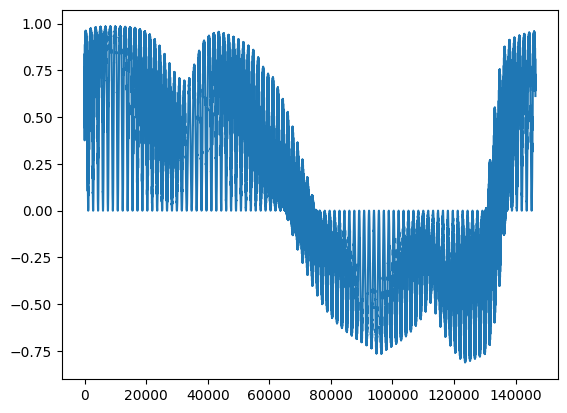

In [34]:

root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

# c = C(440, nombre="Const", tk=tk, show=True)
# c.doShow()
amp = Sine(C(30, show=True), 
           min=C(0), 
           max=C(1, show=True), 
           show=True)

phase=Sine(C(880, show=True), 
           max=C(1, show=True, nombre='maaax'),
           min=C(.3, show=True, fr=-1, nombre='miin'),
           show=True, nombre='ff'
           ) 

s = Sine(
    C(1), 
    amp=C(1, show=True),
    phase=phase,
    # nombre="Seno", 
    show=True
    )

s1 = Triangle(
    C(440), 
    amp=deepcopy(amp),
    phase=s,
    # nombre="Seno", 
    show=True
    )

s2 = Sine(
    C(440), 
    amp=deepcopy(amp),
    phase=deepcopy(phase),
    # nombre="Seno", 
    show=True
    )

# freq = Sine(C(4), 
#             max=C(440, show=True), 
#             min=C(220, show=True),
#             show=True) 

# s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1))
# s.doShow(tk)

freq = Sine(C(5000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)

# s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1), show=True)

tk.pack(side=LEFT)

a = C(1, show=True, nombre="general")
# a.doShow(tk)

synt = Synt(C(1), s, amp=a, show=True, nombre="Synt")
synt = HarmSynt(C(1), [C(1/12, show=True), C(1*4/12, show=True), C(.5*8/12, show=True)], [s1, s2, deepcopy(s1)], show=True, fmix=tanh, amp=a)
env = EnvInstrumento(.2, .1, .7, .2, show=True)

inst = Instrumento(synt, env) # cutre
inst.doShow(tk)
# root.pack(side=TOP)
# input = Mixer([inst], tanh)
input = inst
# input=Echo(inst, 0.5, 0.1)
root.mainloop()
input = None

showOsc(synt, 3)
# showOsc(s1, 3)


Uso del sampler y el sampler cíclico

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


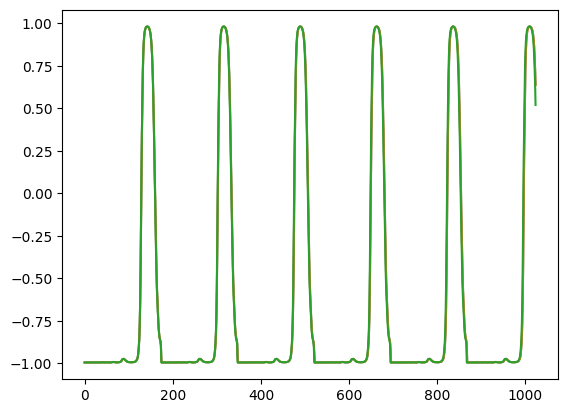

In [35]:
input = None
a = C(1, show=True, nombre="general")

root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")

freq = Sine(C(5000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)

s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1), show=True)
# sol
synt = HarmSynt(C(3322, show=True, to=5000, step=1), [C(1/12, show=True), C(1*4/12, show=True), C(.5*8/12, show=True)], [s1, deepcopy(s1), deepcopy(s1)], show=True, fmix=tanh, amp=a)
# input = synt
# synt.doShow(tk)
# tk.pack()
# root.mainloop()
# showOsc(synt, CHUNK)

onda = []
for i in range(0, int(209*2)):
    onda = np.concatenate((onda, synt.next()))
# plt.plot(onda[:CHUNK])
synt = HarmSynt(C(3322, show=True, to=5000, step=1), [C(1/12, show=True), C(1*4/12, show=True), C(.5*8/12, show=True)], [s1, deepcopy(s1), deepcopy(s1)], show=True, fmix=tanh, amp=a)
rsamp = RSampler(C(3322), onda, og_freq=C(3322))
samp = Sampler(C(3322), onda, C(3322))
showOsc(rsamp, 1, True)
showOsc(samp, 1, True)
showOsc(synt, 1, True)
input = rsamp


In [ ]:
input = None

# MIAU
    necesario usar python 3.12 o inferior (por librosa)

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


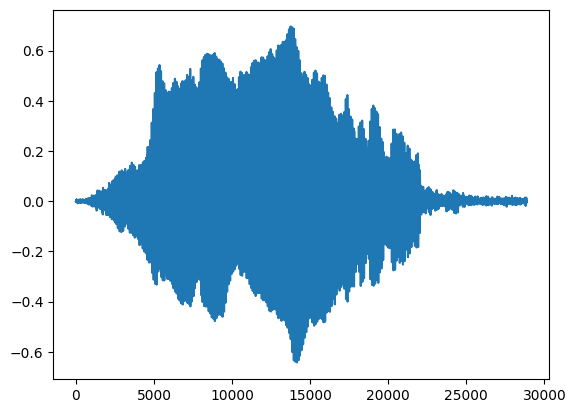

In [6]:
data, sr = librosa.load("miau.wav", sr=SRATE)
data = data[2000:]
plt.plot(data[:SRATE])
# miau
s = Sampler(C(880), data)
input = s

In [ ]:
s = Sampler(C(880), data, C(3000))
input = s

In [ ]:
# data = Sine(C(440)).next()
s = Sampler(C(440), data, og_freq=C(880), samedur=False)
s2 = Sampler(C(440), data, og_freq=C(880), samedur=True)

# s = Sine(C(1))
# gato en burbuja
# synt = Synt(C(1), s, amp=Sine(C(30, show=True), min=C(0, show=True), max=C(1, show=True), show=True), show=True)

#coro de gatos (suena un poco raro)
# synt = HarmSynt(C(1), [C(1), C(3/2), C(9/8)], [s2])

# gato
synt = Synt(C(1), s, amp=C(1, show=True), show=True)


env = EnvInstrumento(.0, 1, 1, .5, show=True)
inst = Instrumento(synt, env) # cutre
root = Tk()
tk = LabelFrame(root, text="Prueba", bg="#808090")


inst.doShow(tk)
input = inst
tk.pack(side=LEFT)
root.mainloop()
input=None
# inst.noteOn(48)

# plt.plot(np.concatenate((data, data, data, data, data)))
# showOsc(inst, 5, True)


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
off
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
noteOn 61 (1108.7305239074883Hz)
noteOff 61 (1108.7305239074883Hz)
noteOn 62 (1174.6590716696303Hz)
noteOff 62 (1174.6590716696303Hz)
off
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
off
off
noteOn 48 (261.6255653005986Hz)
noteOff 48 (261.6255653005986Hz)
noteOn 48 (261.6255653005986Hz)
noteOff 48 (261.6255653005986Hz)
noteOn 48 (261.6255653005986Hz)
noteOff 48 (261.6255653005986Hz)
noteOn 50 (293.6647679174076Hz)
noteOff 50 (293.6647679174076Hz)
noteOn 50 (293.6647679174076Hz)
noteOff 50 (29

In [ ]:
input = None
def callback(outdata, frames, time, status):    
    if status: print(status)    
    #print(inputs)
    s = np.sum([i.next() for i in inputs],axis=0)
    s = np.float32(s)
    outdata[:] = s.reshape(-1, 1)

# os.system('xset r off')
tk = Tk()

inst0 = Instrumento(Synt(C(1), Sine(C(1)), amp=C(1, show=True)), deepcopy(env))

seq = MidiSequencerTk(tk,[inst, inst0])
#print(seq.seq)
inputs = [inst, inst0]

stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
stream.start()

tk.mainloop()

stream.close()

noteOn 48 (130.8127826502993Hz)
noteOff 48 (130.8127826502993Hz)
noteOn 50 (146.8323839587038Hz)
noteOff 50 (146.8323839587038Hz)
noteOn 52 (164.81377845643496Hz)
noteOff 52 (164.81377845643496Hz)
off
noteOn 52 (164.81377845643496Hz)
noteOff 52 (164.81377845643496Hz)
off
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
off
off
noteOff 52 (659.2551138257398Hz)
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
off
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off


# 2. SAMPLER CON ATK Y SUSTAIN

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


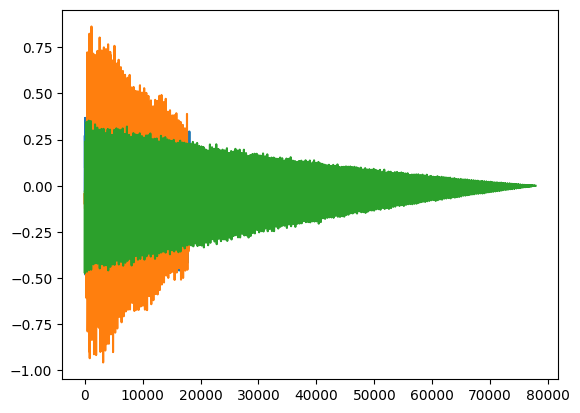

In [ ]:
data_atk, _ = librosa.load("piano_atk.wav", sr=SRATE)
data_rel, _ = librosa.load("piano_rel.wav", sr=SRATE)
data_sus, _ = librosa.load("piano_sus.wav", sr=SRATE)
plt.plot(data_sus)
plt.plot(data_atk)
plt.plot(data_rel)

In [ ]:
input = None
def callback(outdata, frames, time, status):    
    if status: print(status)    
    #print(inputs)
    s = np.sum([i.next() for i in inputs],axis=0)
    s = np.float32(s)
    outdata[:] = s.reshape(-1, 1)

os.system('xset r off')
tk = Tk()

# s_atk = Sampler(C(440), data_atk, og_freq=C(880), samedur=False)
# s_sus = Sampler(C(440), data_sus, og_freq=C(880), samedur=False)
# s_rel = Sampler(C(440), data_rel, og_freq=C(880), samedur=False)

samplefreq = 440
s = InstSampler(C(440), data_atk, C(samplefreq), data_sus, C(samplefreq), data_rel, C(samplefreq))

# gato
synt = Synt(C(1), s, amp=C(1, show=True), show=True)

env = EnvInstrumento(.0, 1, 1, .5, show=True)
inst = Instrumento(synt, env) # cutre

seq = MidiSequencerTk(tk,[inst])
#print(seq.seq)
inputs = [inst]

stream = sd.OutputStream(samplerate=SRATE, channels=1, blocksize=CHUNK, callback=callback)
stream.start()

tk.mainloop()

stream.close()

noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
noteOn 53 (698.4564628660078Hz)
noteOff 53 (698.4564628660078Hz)
off
noteOn 55 (783.9908719634985Hz)
off
noteOff 55 (783.9908719634985Hz)
noteOn 59 (987.7666025122483Hz)
off
noteOff 59 (987.7666025122483Hz)
off
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151Hz)
noteOn 52 (659.2551138257398Hz)
noteOff 52 (659.2551138257398Hz)
off
noteOn 53 (698.4564628660078Hz)
noteOff 53 (698.4564628660078Hz)
off
noteOn 55 (783.9908719634985Hz)
off
noteOff 55 (783.9908719634985Hz)
noteOn 57 (880.0Hz)
off
noteOff 57 (880.0Hz)
noteOn 59 (987.7666025122483Hz)
noteOff 59 (987.7666025122483Hz)
off
off
off
noteOn 48 (523.2511306011972Hz)
noteOff 48 (523.2511306011972Hz)
noteOn 50 (587.3295358348151Hz)
noteOff 50 (587.3295358348151H

In [ ]:

# freq = C(440)

freq = Sine(C(20000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)


s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1))
s2 = Rep(freq, XP(valor=freq, exp=C(1/4)) * C(3) - C(2))
# s2 = Rep(C(440), XP(valor=C(440), pow=C(2)) * C(2) - C(1), phase=Sine(C(440)))
s3 = Sawtooth(freq, phase=C(np.pi/2))
showOsc(s1, 1, True)
showOsc(s2, 1, True)
showOsc(s3, 1, True)
input = s1

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


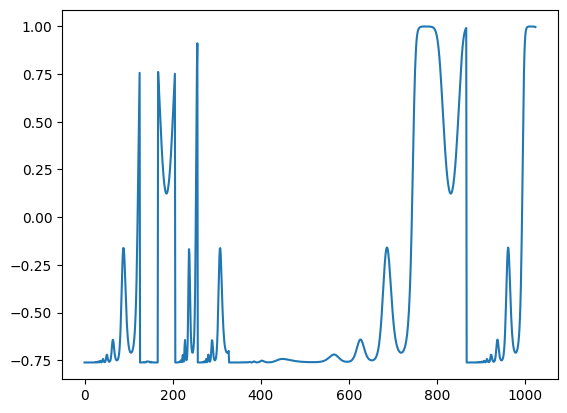

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


In [6]:
freq = Sine(C(5000) / X(avoid0=True), 
            max=C(440, show=True), 
            min=C(220, show=True),
            show=True)


s1 = Rep(freq, XP(valor=freq, exp=C(4)) * C(2) - C(1))
s = Mixer([s1], tanh)
input = s
showOsc(s, 1, chunks=True)

# FILTROS

In [36]:
# %%writefile synt/filter.py

from synt.function import *
from synt.const import *
from tkinter import *
import numpy as np

from synt.osc import *

# TODO ver si satura
class FilterIIR(Function):
    ''' recibe una funcion (generador de ondas) y devuelve su onda filtrada'''
    def __init__(self,signal:Function,alpha:Function, nombre='IIR',show=True):
        super().__init__(show, nombre)
        self.signal = signal
        self.mem = 0
        
        self.alpha = alpha
        if isinstance(alpha, Const):
            self.alpha_mem = alpha.next(np.arange(0, CHUNK))
        else:
            self.alpha_mem = 0
        # self.step = step 
        # por defecto inactivo
        self.act = False

    def fun(self, tiempo):
        data = self.signal.next(tiempo)
        
        if isinstance(self.alpha, Const):
            _alpha = np.full(CHUNK, self.alpha.next(tiempo))
        else:
            _alpha = self.alpha.next(tiempo)
        
        if self.act:
            data[0] = self.mem + self.alpha_mem * (data[0]-self.mem)
            for i in range(1,CHUNK):
                data[i] = data[i-1] + _alpha[i] * (data[i]-data[i-1])
            self.mem = data[CHUNK-1]
            
        self.mem = data[-1] # actualizamos memo con ultima muestra
        self.alpha_mem = float(_alpha[-1])
        
        return data

    def activate(self):
        self.act = True

    def deactivate(self):
        self.act = False    

    def isActive(self):
        return self.act

    def doShow(self, tk, bg="#808090", side=TOP):
        _tk = super().doShow(tk, bg, side=TOP)
        # TODO hacer un boton para activar/desactivar
        self.alpha.addNombre('alpha')
        self.alpha.doShow(_tk, bg, side)
        
        return _tk
    # no hace falta teniendo el do show
    # def upAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha+self.step))

    # def downAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha-self.step))


In [37]:
loop, _ = librosa.load("loop.wav", sr=SRATE)
rsamp = RSampler(C(440, show=True), loop, C(400), C(1))
alpha =  C(1, show=True, step=0.01, fr=0, to=2)
# alpha = Sine(freq=C(0.5, show=True), max=C(1, to=2, show=True), min=C(.5, to=2, show=True), show=True)

filt = FilterIIR(rsamp, alpha)
f = 1
for i in range(0, f):
    filt = FilterIIR(filt, alpha)
# synt = Synt(C(1), filt, C(1, show=True))

tk = Tk()
input = filt
filt.activate()
filt.doShow(tk)
tk.mainloop()
# showOsc(filt, .2)
# showOsc(rsamp, .2)
# TODO arreglar perdida en la amplitud y en la fase

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


intentando hacer un filtro de bajos

In [38]:
# %%writefile synt/filter.py
from copy import deepcopy
from synt.function import *
from synt.const import *
from tkinter import *
import numpy as np

from synt.osc import *

# TODO ver si satura
class FilterIIR(Function):
    ''' recibe una funcion (generador de ondas) y devuelve su onda filtrada'''
    def __init__(self,signal:Function,alpha:Function, act=False, nombre='IIR',show=True):
        super().__init__(show, nombre)
        self.signal = signal
        self.mem = 0
        
        self.alpha = alpha
        _am = alpha.next(np.arange(0, CHUNK))
        
        if isinstance(_am, (list, np.ndarray)):
            self.alpha_mem = _am
        else:
            self.alpha_mem = 0
        # self.step = step 
        # por defecto inactivo
        self.act = act

    def fun(self, tiempo):
        data = self.signal.next(tiempo)
        
        _alf = self.alpha.next(tiempo)
        if isinstance(_alf, (list, np.ndarray)):
            _alpha = _alf
        else:
            _alpha = np.full(CHUNK, _alf)
        
        if self.act:
            data[0] = self.mem + self.alpha_mem * (data[0]-self.mem)
            for i in range(1,CHUNK):
                data[i] = data[i-1] + _alpha[i] * (data[i]-data[i-1])
            self.mem = data[CHUNK-1]
            
        self.mem = data[-1] # actualizamos memo con ultima muestra
        self.alpha_mem = float(_alpha[-1])
        
        return data

    def toggle(self):
        self.act = not self.act

    def activate(self):
        self.act = True

    def deactivate(self):
        self.act = False    

    def isActive(self):
        return self.act

    def doShow(self, tk, bg="#808090", side=TOP):
        _tk = super().doShow(tk, bg, side=TOP)
        # TODO hacer un boton para activar/desactivar
        self.alpha.addNombre('alpha')
        self.alpha.doShow(_tk, bg, side)
        act_button = Button(_tk, text='on/off', command=self.toggle)
        act_button.pack()
        return _tk
    # no hace falta teniendo el do show
    # def upAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha+self.step))

    # def downAlpha(self):
        # self.alpha = min(2.0,max(0.1,self.alpha-self.step))

class LPFilter(FilterIIR):
    def __init__(self,signal:Function,alpha:Function, act=False ,nombre='IIR',show=True):
        super().__init__(signal,alpha, nombre='LP',show=True)
        # _IIR1 = FilterIIR(Reverse(deepcopy(self.signal)), self.alpha, self.act)
        self.lp_0 = FilterIIR(deepcopy(self.signal), self.alpha, self.act)
        self.lp = FilterIIR(Reverse(self.lp_0), self.alpha, self.act)
        
    def fun(self, tiempo):
        if self.act:
            return self.lp_0.next(tiempo)
        else: 
            return self.signal.next(tiempo)
        # aplicamos dos veces para corregir el desplazamiento de fase
        
    def activate(self):
        self.act = True
        self.lp_0.activate()
        self.lp.activate()

    def deactivate(self):
        self.act = False  
        self.lp_0.deactivate()
        self.lp.deactivate

class HPFilter(FilterIIR):
    def __init__(self,signal:Function,alpha:Function, nombre='IIR',show=True):
        super().__init__(signal,alpha, nombre='LP',show=True)
        self.filt_alpha = C(2) - alpha
        self.lp = LPFilter(signal,self.filt_alpha, self.act)
    
    def fun(self, tiempo):
        if self.act:
            _sig = self.signal.next(tiempo)
            _lp = self.lp.next(tiempo)
            '''suena muy bajo'''
            return _sig - _lp
        else: 
            return self.signal.next(tiempo)
        
    def activate(self):
        self.act = True
        self.lp.activate()

    def deactivate(self):
        self.act = False  
        self.lp.deactivate

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


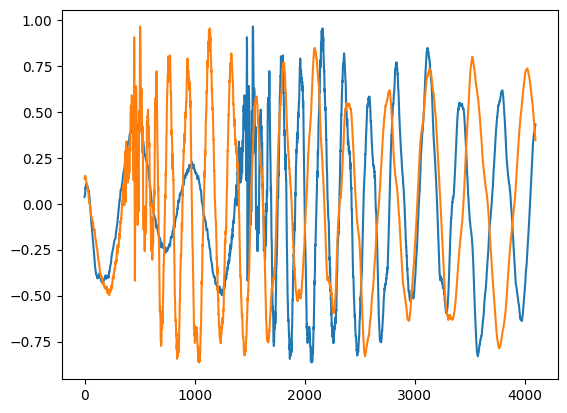

In [39]:
loop, _ = librosa.load("loop.wav", sr=SRATE)
rsamp = RSampler(C(440, show=True), loop, C(400), C(1))
alpha =  C(.5, show=True, step=0.01, fr=0, to=2)
# alpha = Sine(freq=C(0.5, show=True), max=C(1, to=2, show=True), min=C(.5, to=2, show=True), show=True)

filt = LPFilter(rsamp, alpha)
# synt = Synt(C(1), filt, C(1, show=True))

tk = Tk()
input = filt
filt.activate()
filt.doShow(tk)
tk.mainloop()
showOsc(rsamp, .1)
showOsc(filt, .1)

ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


filter LP: off
filter LP: on
filter LP: off
filter LP: on


ALSA lib pcm.c:8772:(snd_pcm_recover) underrun occurred


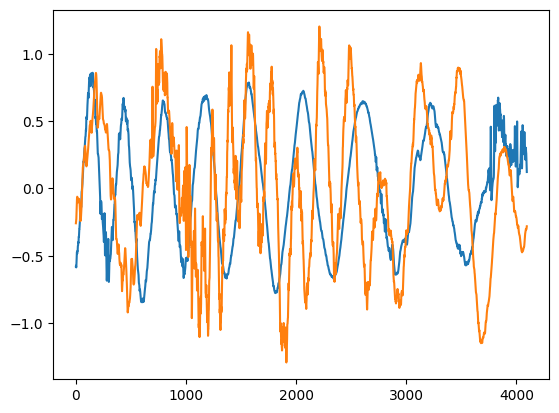

In [16]:
loop, _ = librosa.load("loop.wav", sr=SRATE)
rsamp = RSampler(C(440, show=True), loop, C(400), C(1))
alpha =  C(.5, show=True, step=0.01, fr=0, to=2)
# alpha = Sine(freq=C(0.5, show=True), max=C(1, to=2, show=True), min=C(.5, to=2, show=True), show=True)

''' no funciona del todo bien, '''
filt = HPFilter(rsamp, alpha)
# synt = Synt(C(1), filt, C(1, show=True))

tk = Tk()
input = filt
filt.activate()
filt.doShow(tk)
tk.mainloop()
showOsc(rsamp, .1)
showOsc(filt, .1)